In [ ]:
# prompt: 코랩에서 한글을 출력할 수 있게 해주세요

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf



In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os, re
from glob import glob
from tqdm import tqdm
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import display

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=66ef786538650" -O "data.zip"
!unzip  -O cp949 "data.zip" -d "data"

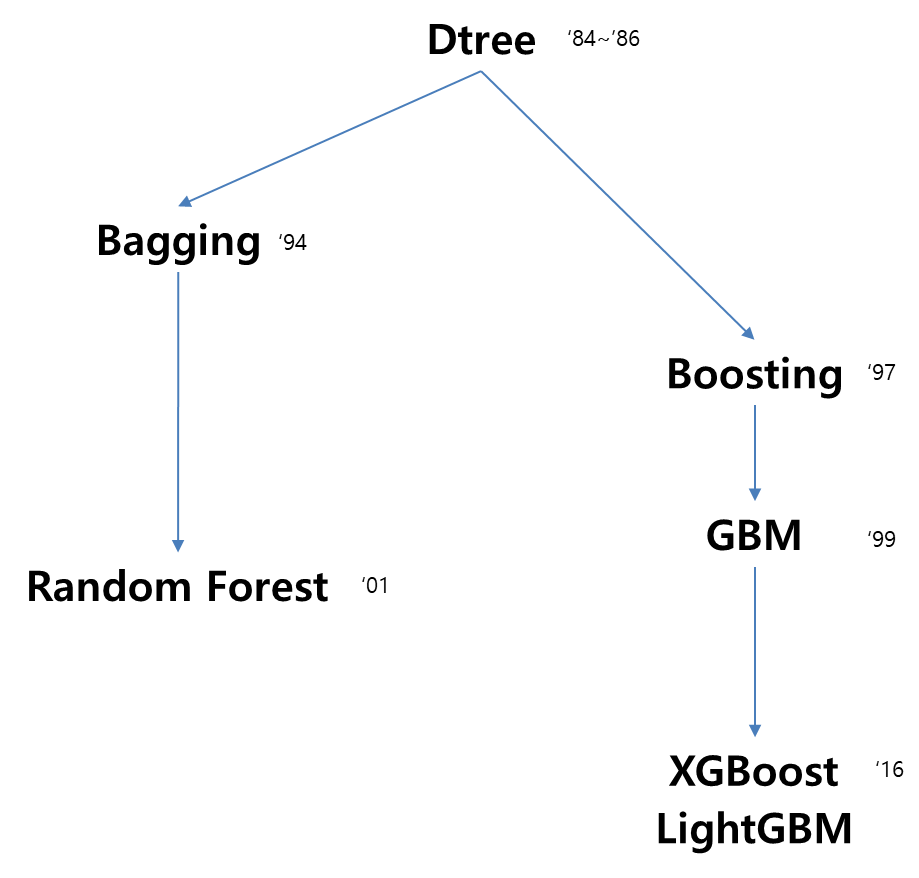

# **Adaboost (Adaptive Boosting)**

### 약한 분류기(weak learner)를 여러 개 연결하여 강한 분류기(Strong Learner)를 생성하는 메타 알고리즘


1. 학습데이터 세트 내 모든 데이터의 선택 확률 동일하게 초기화 (𝑤_𝑖)
2. 선택확률을 이용해 데이터 샘플 복원 추출
3. Weak Learner 모델을 이용하여 학습 (𝐺_𝑚)
4. 사용한 데이터 샘플로 학습 정확도 계산 (〖𝑒𝑟𝑟〗_𝑚)
5. 모델 가중치를 계산 (𝛼_𝑚)
6. 학습데이터 선택 확률 갱신 (𝑤_𝑖)
7. 2~6번 반복 (𝑀)
8. 최종 모델 (𝐺)



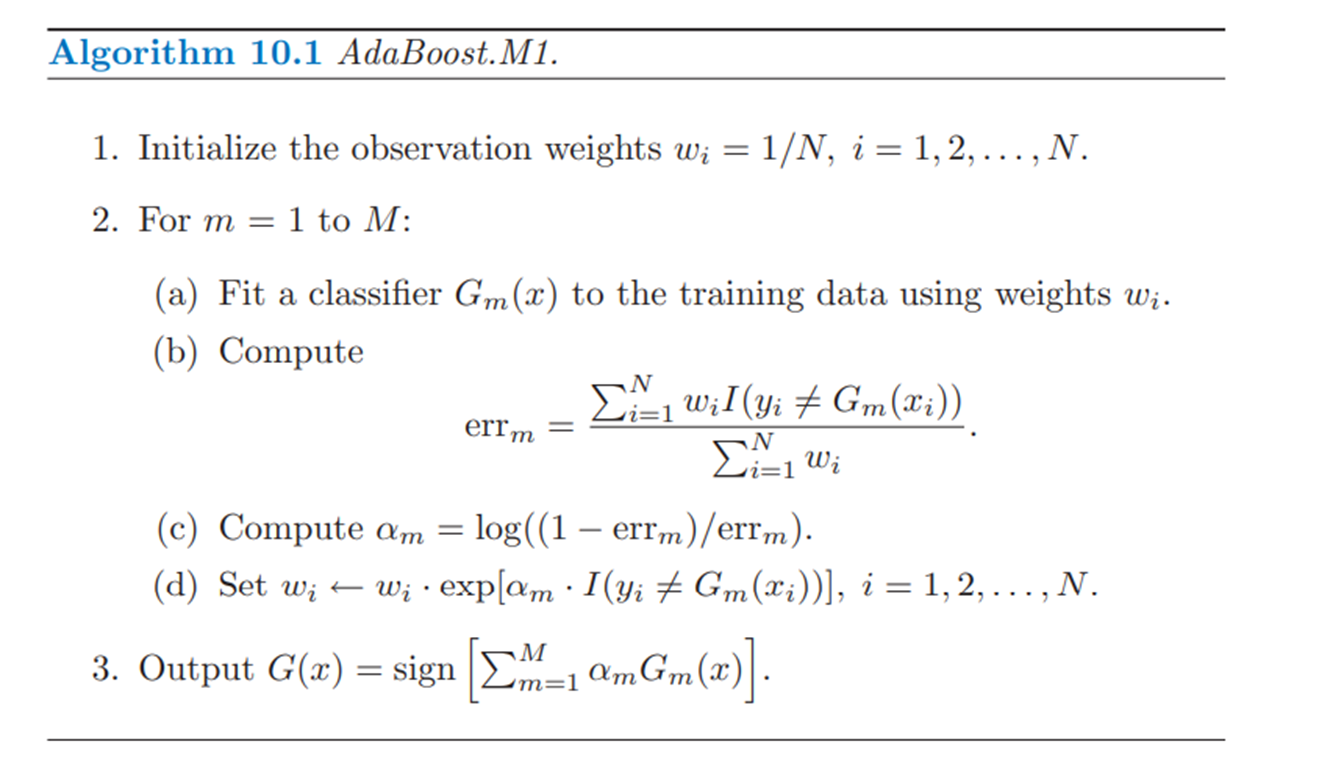

In [ ]:

def GiniIndex(y):
    total = len(y)
    G = 1
    for c in np.unique(y):  # 종속변수의 갯수로 loop
        # print(str(c) + "값 : " + str(np.power(np.where(y == c, 1, 0).sum() / total, 2)))
        G = G - np.power(np.where(y == c, 1, 0).sum() / total, 2)
    return G


"""분할 기준 찾기"""


def split_loop(x, y):
    criteria = x
    criteria = np.sort(np.unique(criteria))
    total = len(y)
    I = np.array([])
    for f, l in zip(criteria[:-1], criteria[1:]):
        split = np.mean([f, l])

        s1 = y[np.where(x < split, True, False)]
        s2 = y[np.where(x > split, True, False)]

        Gini = len(s1) / total * GiniIndex(s1) + len(s2) / total * GiniIndex(s2)

        I = np.append(I, np.array([f, l, split, Gini]))

    I = I.reshape(int(I.shape[0] / 4), 4)
    return I


def display_chart(x, y, s=False, splitter=-1, split=0):
    """ plot으로 고온그룹과 저온그룹을 2차원에 표시"""

    if y.shape[0] == s.shape[0]:
        s[np.where(s[:, 0] < 0.0001, True, False)] = 4
        s[np.where(s[:, 0] < 0.001, True, False)] = 16
        s[np.where(s[:, 0] < 0.002, True, False)] = 32
        s[np.where(s[:, 0] < 0.003, True, False)] = 64
        s[np.where(s[:, 0] < 0.005, True, False)] = 128
        s[np.where(s[:, 0] < 1, True, False)] = 256
    else:
        s = np.full((y.shape[0], 1), 2)

    x1 = x[np.where(y[:, 0] == 1, True, False)]
    y1 = y[np.where(y[:, 0] == 1, True, False)]
    s1 = s[np.where(y[:, 0] == 1, True, False)]

    x2 = x[np.where(y[:, 0] == -1, True, False)]
    y2 = y[np.where(y[:, 0] == -1, True, False)]
    s2 = s[np.where(y[:, 0] == -1, True, False)]

    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (7, 7)
    plt.rcParams['font.size'] = 7

    fig, ax = plt.subplots()

    ax.scatter(x=x1[:, 0], y=x1[:, 1], s=s1, marker='o', color='red', label='고온')
    ax.scatter(x=x2[:, 0], y=x2[:, 1], s=s2, marker='o', color='blue', label='저온')
    # ax.legend(fontsize=20)

    if splitter == 0:
        ax.axvline(x=split, color='r', linewidth=1)

        y_small = y[np.where(x[:, 0] < split, True, False)]
        if y_small.sum() >= 0:  # 고온임
            ax.add_patch(patches.Rectangle((0, 0), split, x[:, 1].max(), facecolor='red', fill=True, alpha=0.1))
        else:
            ax.add_patch(patches.Rectangle((0, 0), split, x[:, 1].max(), facecolor='blue', fill=True, alpha=0.1))

        y_big = y[np.where(x[:, 0] > split, True, False)]
        if y_big.sum() >= 0:  # 고온임
            ax.add_patch(
                patches.Rectangle((split, 0), x[:, 0].max(), x[:, 1].max(), facecolor='red', fill=True, alpha=0.1))
        else:
            ax.add_patch(
                patches.Rectangle((split, 0), x[:, 0].max(), x[:, 1].max(), facecolor='blue', fill=True, alpha=0.1))

    if splitter == 1:
        ax.axhline(y=split, color='r', linewidth=1)

        y_small = y[np.where(x[:, 1] < split, True, False)]
        if y_small.sum() >= 0:  # 고온임
            ax.add_patch(patches.Rectangle((0, 0), x[:, 0].max(), split, facecolor='red', fill=True, alpha=0.1))
        else:
            ax.add_patch(patches.Rectangle((0, 0), x[:, 0].max(), split, facecolor='blue', fill=True, alpha=0.1))

        y_big = y[np.where(x[:, 1] > split, True, False)]

        if y_big.sum() >= 0:  # 고온임
            ax.add_patch(
                patches.Rectangle((0, split), x[:, 0].max(), x[:, 1].max(), facecolor='red', fill=True, alpha=0.1))
        else:
            ax.add_patch(
                patches.Rectangle((0, split), x[:, 0].max(), x[:, 1].max(), facecolor='blue', fill=True, alpha=0.1))

    plt.show()

In [ ]:

# %%
"""학습용 데이터셋을 불러옴"""

sdot_data_total = pd.read_csv('data/sdot학습데이터.csv', sep='|', encoding='cp949')
sdot_data_total = sdot_data_total[~sdot_data_total['공'].isnull()]
"""전체 Sdot 평균기온과의 온도차 평균이 높으면 1, 낮으면 -1으로 종속변수 생성"""
sdot_data_total['종속'] = sdot_data_total['온도차이'].apply(lambda x: -1 if x < 0 else 1)

tmp = sdot_data_total
tmp = sdot_data_total[['도', '대', '종속']].fillna(0)

"""학습을 위하 pandas를 numpy로 변환하여 x와 y 배열 생성"""
x = np.array(tmp[['도', '대']].astype('float').values)
y = np.array(tmp['종속'].values)
y = y.reshape(y.shape[0], 1)  # x배열과 shape를 같게 reshape


In [ ]:
display_chart(x, y, np.full((y.shape[0], 1), 4))

In [ ]:
cnt = x.shape[0]  # 전체 데이터 수를 샌다
# x_proba = np.concatenate((np.linspace(0, cnt-1, cnt).reshape(cnt, 1), np.full((cnt,1), 1/cnt)), axis=1)
x_proba = np.full((cnt, 1), 1 / cnt)  # 모든 데이터 샘플의 선택확률을 동일하게 부여한다

np.random.seed(0)  # 랜덤시드 고정
idxs = np.random.choice(cnt, cnt, p=x_proba[:, 0])  # 샘플 복원추출 시작

x_1 = x[idxs]
y_1 = y[idxs]

# display_chart(x_1, y_1, x_proba[idxs].copy()) #추출된 데이터셋 출력

# Gini Index 루프로 분할 기준 정하기
I1 = split_loop(x_1[:, 0], y_1)
I2 = split_loop(x_1[:, 1], y_1)

# 분할 기준 확인
if I1[:, 3].min() <= I2[:, 3].min():
    splitter = 0
    split = I1[np.where(I1[:, 3] == I1[:, 3].min(), True, False)][0, 2]
else:
    splitter = 1
    split = I2[np.where(I2[:, 3] == I2[:, 3].min(), True, False)][0, 2]

# 분할 결과 확인
display_chart(x_1, y_1, x_proba[idxs].copy(), splitter, split)

In [ ]:
# prompt: x_proba를 히스토그램으로 표시해줘

plt.hist(x_proba, bins=20)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of x_proba (total : ' + format(len(x_proba),",") +')')
plt.show()


In [ ]:
y_small = y_1[np.where(x_1[:, splitter] < split, True, False)]
y_big = y_1[np.where(x_1[:, splitter] > split, True, False)]

# 각 노드별 예측값 결정
y_small = 1 if np.where(y_small == 1, 1, 0).sum() / len(y_small) >= 0.5 else -1
y_big = 1 if np.where(y_big == 1, 1, 0).sum() / len(y_big) >= 0.5 else -1

# 샘플데이터의 예측 값 계산
y_1_pred = np.where(x_1[:, splitter] < split, y_small, y_big)

# 샘플데이터를 이용한 오류율 계산
err = 1 - (y_1_pred == y_1[:, 0]).sum() / y_1.shape[0]
# 대상 모델의 가중치 계산
alpha = np.log((1 - err) / err)

# 전체 데이터의 예측 값 계산
y_pred = np.where(x[:, splitter] < split, y_small, y_big)

# 추출확률 변경 비율 계산
tmp = np.exp(alpha * (y_pred != y[:, 0]))
# 추출 확률 변경
x_proba = x_proba * tmp.reshape(tmp.shape[0], 1)

# display_chart(x, y, x_proba.copy())
# 변경된 추출확률을 그래플 표시, 분류기에서 오답인 데이터셋의 추출확률 증가(표식 크기로 구분)
display_chart(x, y, x_proba.copy(), splitter, split)


plt.hist(x_proba, bins=20)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of x_proba (total : ' + format(len(x_proba),",") +')')
plt.show()

In [ ]:
n_estimator = 20  # 100개 모델
cnt = x.shape[0]  # 전체 데이터 수를 샌다
idxs = np.zeros((n_estimator, cnt), int)
err = np.zeros((n_estimator, 1), float)
alpha = np.zeros((n_estimator, 1), float)

splitter = np.zeros((n_estimator, 1), int)
split = np.zeros((n_estimator, 1), float)
pred_small = np.zeros((n_estimator, 1), int)
pred_big = np.zeros((n_estimator, 1), int)

x_proba = np.full((cnt, 1), 1 / cnt)  # 추출확률 초기화

np.random.seed(0)  # 랜덤시드 고정

bPrint = True
for m in tqdm(range(n_estimator)):
    idxs[m, :] = np.random.choice(cnt, cnt, p=x_proba[:, 0])  # 샘플 복원추출 시작

    x_1 = x[idxs[m, :]]
    y_1 = y[idxs[m, :]]

    # Gini Index 루프로 분할 기준 정하기
    I1 = split_loop(x_1[:, 0], y_1)
    I2 = split_loop(x_1[:, 1], y_1)

    if I1[:, 3].min() <= I2[:, 3].min():
        splitter[m, 0] = 0
        split[m, 0] = I1[np.where(I1[:, 3] == I1[:, 3].min(), True, False)][0, 2]
    else:
        splitter[m, 0] = 1
        split[m, 0] = I2[np.where(I2[:, 3] == I2[:, 3].min(), True, False)][0, 2]

    y_small = y_1[np.where(x_1[:, splitter[m, 0]] < split[m, 0], True, False)]
    y_big = y_1[np.where(x_1[:, splitter[m, 0]] > split[m, 0], True, False)]

    # 각 노드별 예측값 결정
    y_small = 1 if np.where(y_small == 1, 1, 0).sum() / len(y_small) >= 0.5 else -1
    y_big = 1 if np.where(y_big == 1, 1, 0).sum() / len(y_big) >= 0.5 else -1

    pred_small[m, 0] = y_small
    pred_big[m, 0] = y_big

    # 샘플데이터의 예측 값 계산
    y_1_pred = np.where(x_1[:, splitter[m, 0]] < split[m, 0], y_small, y_big)

    # 샘플데이터를 이용한 오류율 계산
    err[m, 0] = 1 - (y_1_pred == y_1[:, 0]).sum() / y_1.shape[0]
    # 대상 모델의 가중치 계산
    alpha[m, 0] = np.log((1 - err[m, 0]) / err[m, 0])

    # 전체 데이터의 예측 값 계산
    y_pred = np.where(x[:, splitter[m, 0]] < split[m, 0], y_small, y_big)

    # 추출확률 변경 비율 계산
    proba_change = np.exp(alpha[m, 0] * (y_pred != y[:, 0]))
    # 추출 확률 변경
    x_proba = x_proba * proba_change.reshape(proba_change.shape[0], 1)
    x_proba = x_proba / x_proba.sum()

    # 변경된 추출확률을 그래플 표시, 분류기에서 오답인 데이터셋의 추출확률 증가(표식 크기로 구분)
    if bPrint:
        display_chart(x_1, y_1, x_proba[idxs[m, :]].copy(), splitter[m, 0], split[m, 0])
        print(str(m + 1) + '번째 모델 / 가중치 : ' + str(alpha[m, 0]))

        # key = input("출력중지(c), 종료(q):")
        # if key == 'q':
        #     break
        # if key == 'c':
        #     bPrint = False
        #     continue

In [ ]:

plt.hist(x_proba, bins=20)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Histogram of x_proba (total : ' + format(len(x_proba),",") +')')
plt.show()

In [ ]:
pred = np.zeros((n_estimator, cnt), float)
for m in range(n_estimator):
    pred[m, :] = np.where(x[:, splitter[m, 0]] < split[m, 0], -1,1)

for i in range(1, n_estimator + 1, 1):
    pred_sum = (pred[:i, :]*alpha[:i,:]).sum(axis=0)
    pred_sum = np.where(pred_sum < np.median(pred_sum), -1, 1)  # 최종예측
    pred_sum = pred_sum.reshape(1031, 1)
    display_chart(x, pred_sum, np.full((pred_sum.shape[0], 1), 4))
    print(str(i) + '번째 모델')
    # key = input("종료(q):")
    # if key == 'q': break
# display_chart(x, y, np.full((y.shape[0],1), 4))

In [ ]:
# prompt: x와 y를 이용해 adaboost 로 분석

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# AdaBoost 모델 생성 및 훈련
model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),  # 약한 학습기로 Decision Tree 사용
    n_estimators=100,  # 100개의 약한 학습기 사용
    learning_rate=1.0  # 학습률
)
model.fit(x, y)

# 테스트 데이터 예측
y_pred = model.predict(x)

# 모델 평가 (정확도)
accuracy = (y_pred == y).sum() / len(y)
print(f"Accuracy: {accuracy}")

# 모델 평가 (기타 지표)
# ... (예: Confusion Matrix, Precision, Recall, F1-score 등)

# 예측 결과를 시각화
display_chart(x, y_pred.reshape(-1, 1), np.full((y_pred.shape[0], 1), 4))


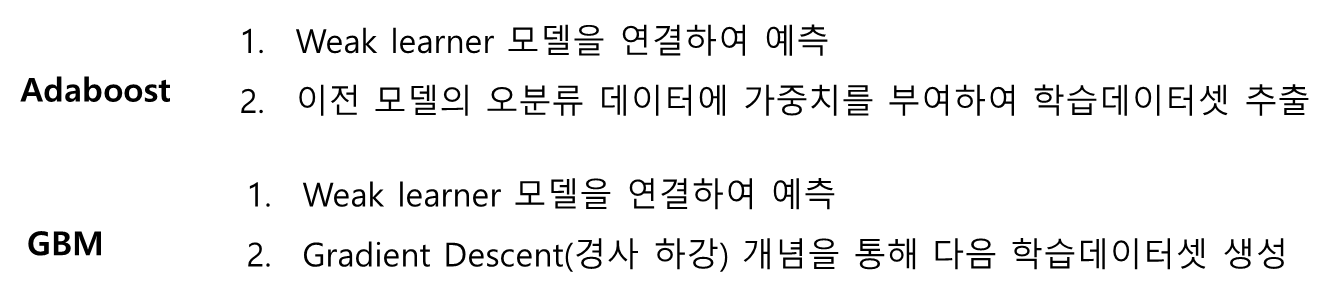

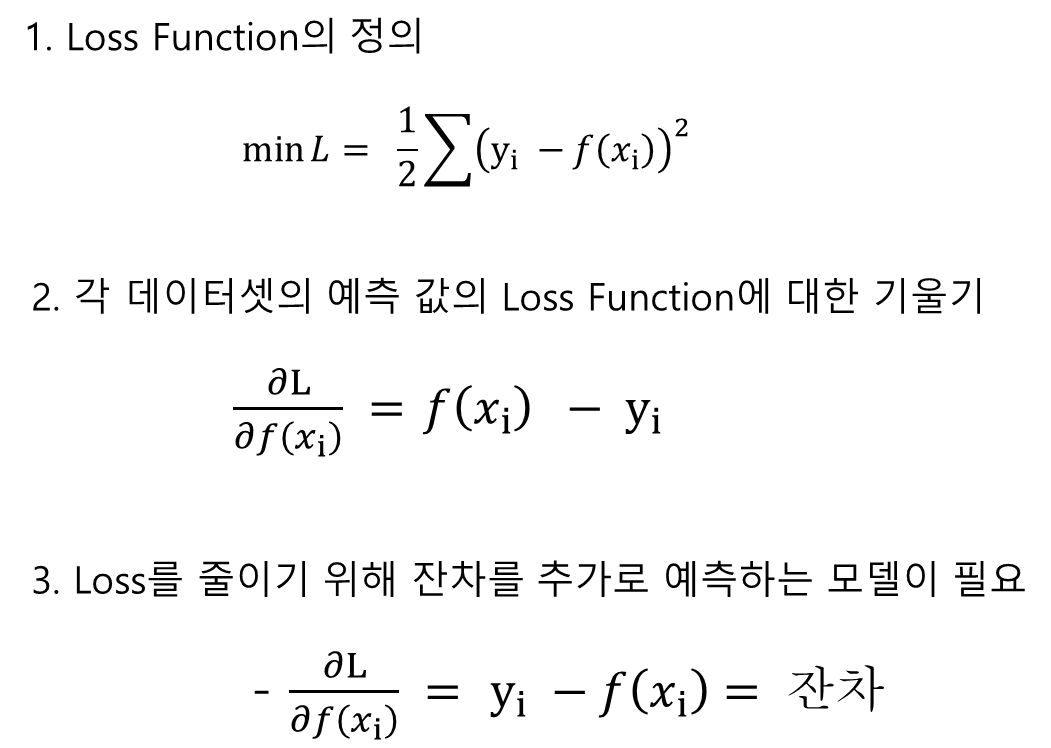

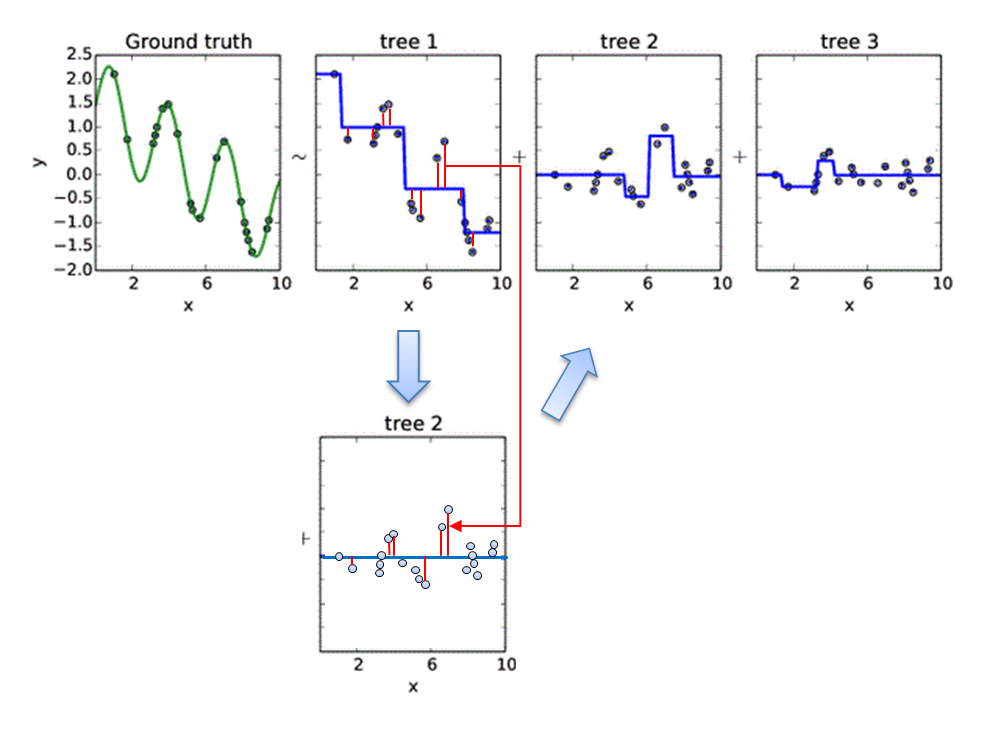

In [ ]:
# prompt: x와 y를 이용해 GBM으로 분석

from sklearn.ensemble import GradientBoostingClassifier

# Assuming x and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create and train the GBM model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


# 테스트 데이터 예측
y_pred = model.predict(x)

# 모델 평가 (정확도)
accuracy = (y_pred == y).sum() / len(y)
print(f"Accuracy: {accuracy}")

# 모델 평가 (기타 지표)
# ... (예: Confusion Matrix, Precision, Recall, F1-score 등)

# 예측 결과를 시각화
display_chart(x, y_pred.reshape(-1, 1), np.full((y_pred.shape[0], 1), 4))

In [ ]:
# prompt: x와 y를 이용해 XGBoost로 분석

# 필요한 라이브러리 설치
!pip install xgboost

# XGBoost 모델 import
from xgboost import XGBClassifier

# x와 y를 이용해 XGBoost 모델 학습
y_train = y.copy()
y_train[np.where(y_train==-1)] = 0

xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(x, y_train)

# 테스트 데이터 예측
y_pred_xgb = xgb_model.predict(x)

y_pred_xgb[np.where(y_pred_xgb==0)] = -1
# 모델 평가 (정확도)
accuracy_xgb = (y_pred_xgb == y_train).sum() / len(y_train)
print(f"XGBoost Accuracy: {accuracy_xgb}")

# 모델 평가 (기타 지표)
# ... (예: Confusion Matrix, Precision, Recall, F1-score 등)

# 예측 결과를 시각화
display_chart(x, y_pred_xgb.reshape(-1, 1), np.full((y_pred_xgb.shape[0], 1), 4))


In [ ]:
# prompt: x와 y를 이용해 LightGBM으로 분석

!pip install lightgbm

from lightgbm import LGBMClassifier

# LightGBM 모델 학습
y_train = y.copy()
y_train[np.where(y_train==-1)] = 0

lgbm_model = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
lgbm_model.fit(x, y_train)

# 테스트 데이터 예측
y_pred_lgbm = lgbm_model.predict(x)

y_pred_lgbm[np.where(y_pred_lgbm==0)] = -1

# 모델 평가 (정확도)
accuracy_lgbm = (y_pred_lgbm == y).sum() / len(y)
print(f"LightGBM Accuracy: {accuracy_lgbm}")

# 모델 평가 (기타 지표)
# ... (예: Confusion Matrix, Precision, Recall, F1-score 등)

# 예측 결과를 시각화
display_chart(x, y_pred_lgbm.reshape(-1, 1), np.full((y_pred_lgbm.shape[0], 1), 4))


In [ ]:
# prompt: x와 y를 이용해 catboost로 분석

!pip install catboost

from catboost import CatBoostClassifier

# CatBoost 모델 학습
y_train = y.copy()
y_train[np.where(y_train==-1)] = 0

catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_state=42)
catboost_model.fit(x, y_train)

# 테스트 데이터 예측
y_pred_catboost = catboost_model.predict(x)

y_pred_catboost[np.where(y_pred_catboost==0)] = -1

# 모델 평가 (정확도)
accuracy_catboost = (y_pred_catboost == y).sum() / len(y)
print(f"CatBoost Accuracy: {accuracy_catboost}")

# 모델 평가 (기타 지표)
# ... (예: Confusion Matrix, Precision, Recall, F1-score 등)

# 예측 결과를 시각화
display_chart(x, y_pred_catboost.reshape(-1, 1), np.full((y_pred_catboost.shape[0], 1), 4))
